# Anticipez les besoins en consommation de b√¢timents - *Notebook exploratoire*

## Mission

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en √©missions de carbone en 2050, votre √©quipe s‚Äôint√©resse de pr√®s √† la consommation et aux √©missions des b√¢timents non destin√©s √† l‚Äôhabitation.

Des relev√©s minutieux ont √©t√© effectu√©s par les agents de la ville en 2016. Cependant, ces relev√©s sont co√ªteux √† obtenir, et √† partir de ceux d√©j√† r√©alis√©s, vous voulez tenter de pr√©dire les √©missions de CO2 et la consommation totale d‚Äô√©nergie de b√¢timents non destin√©s √† l‚Äôhabitation pour lesquels elles n‚Äôont pas encore √©t√© mesur√©es.

Votre pr√©diction se basera sur les donn√©es structurelles des b√¢timents (taille et usage des b√¢timents, date de construction, situation g√©ographique, ...)

Vous cherchez √©galement √† √©valuer l‚Äôint√©r√™t de l‚ÄôENERGY STAR Score pour la pr√©diction d‚Äô√©missions, qui est fastidieux √† calculer avec l‚Äôapproche utilis√©e actuellement par votre √©quipe. Vous l'int√©grerez dans la mod√©lisation et jugerez de son int√©r√™t.

Vous sortez tout juste d‚Äôune r√©union de brief avec votre √©quipe. Voici un r√©capitulatif de votre mission :


1) R√©aliser une courte analyse exploratoire.
2) Tester diff√©rents mod√®les de pr√©diction afin de r√©pondre au mieux √† la probl√©matique.

Fais bien attention au traitement des diff√©rentes variables, √† la fois pour trouver de nouvelles informations (peut-on d√©duire des choses int√©ressantes d‚Äôune simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une √©valuation rigoureuse des performances, et optimise les hyperparam√®tres et le choix d‚Äôalgorithmes de ML √† l‚Äôaide d‚Äôune validation crois√©e. Tu testeras au minimum 4 algorithmes de famille diff√©rente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

## Analyse exploratoire des datasets et 1er feature engineering

### 1 - D√©couverte du jeu de donn√©es

In [561]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # N√©cessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
# Encodage des variables cat√©gorielles avant d'utiliser KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# pour le centrage et la r√©duction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import dummy
from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC

from sklearn import kernel_ridge

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)
print("tensorflow version", tensorflow.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
tensorflow version 2.18.0


In [5]:
# Charger le fichier de donn√©es
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [6]:
data.shape

(3376, 46)

In [7]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

On voit d√©j√† des valeurs aberrantes. Par exemple les valeurs de SourceEUIWN(kBtu/sf) et Electricity(kWh) sont n√©gatives.

In [9]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


OSEBuildingID                        0.00
PropertyGFABuilding(s)               0.00
PropertyGFAParking                   0.00
PropertyGFATotal                     0.00
NumberofFloors                       0.00
YearBuilt                            0.00
Longitude                            0.00
Latitude                             0.00
Neighborhood                         0.00
DefaultData                          0.00
CouncilDistrictCode                  0.00
ComplianceStatus                     0.00
State                                0.00
City                                 0.00
Address                              0.00
PropertyName                         0.00
PrimaryPropertyType                  0.00
BuildingType                         0.00
DataYear                             0.00
TaxParcelIdentificationNumber        0.00
SiteEnergyUse(kBtu)                  0.15
SiteEnergyUseWN(kBtu)                0.18
SiteEUIWN(kBtu/sf)                   0.18
SiteEUI(kBtu/sf)                  

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Pour rappel, il y a 3 376 lignes.

In [12]:
list_sort = round((data == 0).mean().sort_values() * 100, 2)
print('Pourcentage de valeurs = 0 par colonne')
list_sort

Pourcentage de valeurs = 0 par colonne


OSEBuildingID                       0.00
Outlier                             0.00
ComplianceStatus                    0.00
Comments                            0.00
ENERGYSTARScore                     0.00
YearsENERGYSTARCertified            0.00
ThirdLargestPropertyUseType         0.00
SecondLargestPropertyUseType        0.00
LargestPropertyUseType              0.00
ListOfAllPropertyUseTypes           0.00
PropertyGFABuilding(s)              0.00
PropertyGFATotal                    0.00
YearBuilt                           0.00
LargestPropertyUseTypeGFA           0.00
Latitude                            0.00
DataYear                            0.00
BuildingType                        0.00
Neighborhood                        0.00
PrimaryPropertyType                 0.00
CouncilDistrictCode                 0.00
TaxParcelIdentificationNumber       0.00
ZipCode                             0.00
State                               0.00
Longitude                           0.00
City            

In [13]:
list_sort = (data == 0).sum().sort_values()
print('Nombres de valeurs = 0 par colonne')
list_sort

Nombres de valeurs = 0 par colonne


OSEBuildingID                         0
Outlier                               0
ComplianceStatus                      0
Comments                              0
ENERGYSTARScore                       0
YearsENERGYSTARCertified              0
ThirdLargestPropertyUseType           0
SecondLargestPropertyUseType          0
LargestPropertyUseType                0
ListOfAllPropertyUseTypes             0
PropertyGFABuilding(s)                0
PropertyGFATotal                      0
YearBuilt                             0
LargestPropertyUseTypeGFA             0
Latitude                              0
DataYear                              0
BuildingType                          0
Neighborhood                          0
PrimaryPropertyType                   0
CouncilDistrictCode                   0
TaxParcelIdentificationNumber         0
ZipCode                               0
State                                 0
Longitude                             0
City                                  0


In [14]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [15]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [16]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [17]:
data['CouncilDistrictCode'].unique()

array([7, 3, 2, 4, 5, 6, 1], dtype=int64)

In [18]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [19]:
data['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'Other - Mall', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Distribution Center', 'Parking', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient', nan,
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Indust

In [20]:
data['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [21]:
mask = (data['Outlier'] == 'High outlier') | (data['Outlier'] == 'Low outlier')
print("Nombre de propri√©t√©s aberrantes : ", data.loc[mask].shape[0])

Nombre de propri√©t√©s aberrantes :  32


In [22]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [23]:
mask = data['ComplianceStatus'].isin(['Non-Compliant'])
print("Nombre de propri√©t√©s not compliant :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Missing Data'])
print("Nombre de propri√©t√©s missing-data :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Error - Correct Default Data'])
print("Nombre de propri√©t√©s error :", data.loc[mask].shape[0])

Nombre de propri√©t√©s not compliant : 37
Nombre de propri√©t√©s missing-data : 15
Nombre de propri√©t√©s error : 113


On constate:
- Il n'y a qu'une seule ann√©e dans le dataset
- Il y a 8 types d'immmeuble (BuildingType)
- Il y a une seule ville : Seattle, dans un seul √©tat
- Il y a 7 districts diff√©rents (CouncilDistrictCode)
- Il y a 19 quartiers (Neighborhood), mais certains sont en double, donc 13 r√©els (nettoyage √† pr√©voir)
- Il y a 55 codes postaux diff√©rents (ZipCode)
- Il y a 113 ann√©es de construction diff√©rentes (yearBuilt)
- Il y a 100 valeurs diff√©rentes pour l'ENERGYSTARScore
- Plusieurs batiments ont la m√™me consommation d'energie, et le m√™me taux d'√©mission de COS
- Quelques b√¢timents ont la m√™me adresse
- La feature 'Outlier' ne contient que 2 valeurs : High outlier et Low outlier. Et 99% des valeurs sont manquantes. Elle n'est donc pas utlisable
- La feature 'ComplianceStatus' contient 4 valeurs : Compliant', 'Error - Correct Default Data', 'Missing Data', et 'Non-Compliant'. Toutes les valeurs sont pr√©sentes.

In [25]:
data.duplicated().sum()

0

Il n'y a pas de donn√©es dupliqu√©es.

### 2 - Choix des variables

#### 2.1 - Sources d'energie

Il y a 3 sources d'energie dans le fichier : electricit√©, vapeur, gaz naturel.

Il faut choisir les sources exprim√©es en kBtu pour pouvoir les comparer entre elles, et d√©terminer la proportion utilis√©e par b√¢timent.

Il s'agit des variables : Electricity(kBtu) , NaturalGas(kBtu), SteamUse(kBtu) 

Ces 3 variables sont assez bien utilis√©es.

#### 2.2 - Donn√©es structurelles

Liste des donn√©es structurelles
- PrimaryPropertyType (usage principal)
- Neighborhood (quartier)
- YearBuilt (ann√©e de construction) - cr√©er des p√©riodes (nouvelle variable cat√©gorielle)
- NumberofBuildings (nombre de b√¢timents)
- NumberofFloors (nombre d'√©tages)
- PropertyGFATotal (surface plancher brute b√¢timent et stationnement)
- PropertyGFAParking (surface totale des stationnements en pieds carr√©s)  - dans un second temps pour l'am√©lioration des mod√®les
- PropertyGFABuilding(s) (surface des b√¢timents hors stationnement en pieds carr√©s)  - dans un second temps pour l'am√©lioration des mod√®les
- LargestPropertyUseType (doublon avec PrimaryPropertyType ???)  - dans un second temps pour l'am√©lioration des mod√®les
- LargestPropertyUseTypeGFA (surface d'utlisation du type d'usage principal)  - dans un second temps pour l'am√©lioration des mod√®les

SecondLargestPropertyUseType et ThirdLargestPropertyUseType ne sont pas suffisamment valoris√©es, respectivement 50% et 82% de valeurs manquantes.

#### 2.3 - Choix des 2 variables cibles


Le dataset ne contient pas la superficie des b√¢timents : faut-il donner les cibles en valeur absolue ? Ou divis√©e par la superficie ?


**Consommation totale d‚Äô√©nergie**

Il y a plusieurs features qui pourraient repr√©senter la consommation totale d'energy. Mais la plus pertinente est 'SiteEnergyUseWN(kBtu)', car :
- Elle est tr√®s bien valoris√©e (0,18 % de valeurs manquantes)
- Elle int√®gre toutes les sources d'energy
- Elle est harmonis√©e
- Sa valeur n'est pas d√©termin√©e en fonction de la superficie du b√¢timent

**√©missions de CO2**

Il y a plusieurs features qui pourraient repr√©senter les √©missions de CO2. Mais la plus pertinente est 'TotalGHGEmissions', car :
- Elle est tr√®s bien valoris√©e (0,27 % de valeurs manquantes)
- Sa valeur n'est pas d√©termin√©e en fonction de la superficie du b√¢timent

#### 2.4 - ENERGYSTARScore

Il est assez mal valoris√©. Il s'agit d'une note de 1 √† 100 calcul√©e, qui √©value la performance √©nerg√©tique globale d'une propri√©t√©, sur la base de donn√©es nationales pour contr√¥ler les diff√©rences entre le climat, les utilisations et les op√©rations du b√¢timent. Un score de 50 repr√©sente la m√©diane nationale.

### 3 - Filter le dataset sur les b√¢timents non destin√©s √† l'habitation

La variable qui permet d'identifier le caract√®re r√©sidentiel ou non est "BuildingType". Elle prend les valeurs suivantes :

In [34]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Si on demande √† ChatGPT de d√©crire ces types, voici ce qu'on obtient :

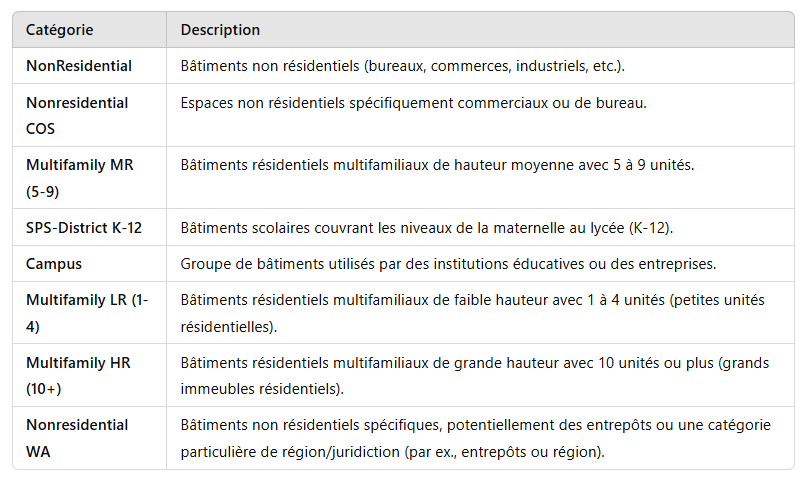

Pour le projet, nous allons donc retenir les cat√©gories suivantes :
- NonResidential
- Nonresidential COS
- SPS-District K-12
- Campus
- Nonresidential WA

In [38]:
building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

In [39]:
mask = data['BuildingType'].isin(building_types)
data = data.loc[mask]
data.shape

(1668, 46)

Il reste la moiti√© des b√¢timents dans le dataset.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1668 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   Address                          1668 non-null   object 
 6   City                             1668 non-null   object 
 7   State                            1668 non-null   object 
 8   ZipCode                          1652 non-null   float64
 9   TaxParcelIdentificationNumber    1668 non-null   object 
 10  CouncilDistrictCode              1668 non-null   int64  
 11  Neighborhood                     1668 non-null   object 
 12  Latitude                 

### 4 - Supprimer les produits qui n'ont pas de valeurs cibles

In [43]:
cibles = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [44]:
data.shape

(1668, 46)

**Rechercher et supprimer les valeurs manquantes**

In [46]:
mask = data['SiteEnergyUseWN(kBtu)'].isna()
print(data.loc[mask, ['PropertyName', 'SiteEnergyUseWN(kBtu)']])

                                 PropertyName  SiteEnergyUseWN(kBtu)
563   Market Place I & II-2003 Western Avenue                    NaN
578                          SEATTLE BUILDING                    NaN
2670                         KALBERG BUILDING                    NaN


In [47]:
mask = ~data['SiteEnergyUseWN(kBtu)'].isna()
data = data.loc[mask]

In [48]:
data.shape

(1665, 46)

In [49]:
mask = data['TotalGHGEmissions'].isna()
print(data.loc[mask, ['PropertyName', 'TotalGHGEmissions']])

Empty DataFrame
Columns: [PropertyName, TotalGHGEmissions]
Index: []


Les valeurs de la variable TotalGHGEmissions des lignes supprim√©es √©taient aussi manquantes

**Rechercher et supprimer les valeurs nulles qui sont √† consid√©rer comme manquante**

In [52]:
mask = data['SiteEnergyUseWN(kBtu)'] == 0
print(data.loc[mask, ['PropertyName', 'SiteEnergyUseWN(kBtu)']])

                                     PropertyName  SiteEnergyUseWN(kBtu)
28                                 Meany Building                    0.0
31                            John Hay Elementary                    0.0
62                       Arbor Heights Elementary                    0.0
81                                 Pathfinder K-8                    0.0
85                           John Muir Elementary                    0.0
95                            B.F. Day Elementary                    0.0
133                                Whitman Middle                    0.0
139                             Washington Middle                    0.0
152                       Olympic View Elementary                    0.0
220                               Norton Building                    0.0
247                        Metropolitan Park East                    0.0
284               Onni 1411 Fourth Development LP                    0.0
304            Washington State Convention Center  

In [53]:
mask = ~(data['SiteEnergyUseWN(kBtu)'] == 0)
data = data.loc[mask]

In [54]:
data.shape

(1640, 46)

In [55]:
mask = data['TotalGHGEmissions'] == 0
print(data.loc[mask, ['PropertyName', 'TotalGHGEmissions']])

                  PropertyName  TotalGHGEmissions
513  IUC- Whole Foods Interbay                0.0


In [56]:
mask = ~(data['TotalGHGEmissions'] == 0)
data = data.loc[mask]

In [57]:
data.shape

(1639, 46)

### 5 - Automatiser les √©tapes 3 et 4

In [59]:
# Charger le fichier de donn√©es
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.shape

(3376, 46)

In [60]:
def select_dataset(df):

    # Filter le dataset sur les b√¢timents non destin√©s √† l'habitation
    building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']
    mask = df['BuildingType'].isin(building_types)
    df = df.loc[mask]
    
    # Supprimer les produits qui n'ont pas de valeurs cibles
    ## Rechercher et supprimer les valeurs manquantes
    mask = ~df['SiteEnergyUseWN(kBtu)'].isna()
    df = df.loc[mask]
    mask = ~df['TotalGHGEmissions'].isna()
    df = df.loc[mask]

    ## Rechercher et supprimer les valeurs nulles qui sont √† consid√©rer comme manquantes
    mask = (df['SiteEnergyUseWN(kBtu)'] != 0) & (df['TotalGHGEmissions'] != 0)
    df = df.loc[mask]

    return df    

In [61]:
data = select_dataset(data)
data.shape

(1639, 46)

### 6 - 1er feature engineering

#### 6.1 - Traiter les valeurs manquantes des features de consommation d'energy

In [64]:
mask = (data['Electricity(kBtu)'] == 0) & (data['NaturalGas(kBtu)'] == 0) & (data['SteamUse(kBtu)'] == 0)
print("Nombre de lignes o√π les valeurs des 3 types d'energy sont nulles : ", data.loc[mask].shape[0])

Nombre de lignes o√π les valeurs des 3 types d'energy sont nulles :  0


In [65]:
mask = (data['Electricity(kBtu)'].isna()) & (data['NaturalGas(kBtu)'].isna()) & (data['SteamUse(kBtu)'].isna())
print("Nombre de lignes o√π les valeurs des 3 types d'energy sont manquantes : ", data.loc[mask].shape[0])

Nombre de lignes o√π les valeurs des 3 types d'energy sont manquantes :  0


Il n'y a pas de donn√©es √† supprimer ici.

#### 6.2 - Filtrer sur les variables "Outlier" et "CompliantStatus"

In [68]:
mask = (data['Outlier'] == 'High outlier') | (data['Outlier'] == 'Low outlier')
print("Nombre de propri√©t√©s aberrantes : ", data.loc[mask].shape[0])

Nombre de propri√©t√©s aberrantes :  17


Comme le nombre de propri√©t√© aberrantes concerne 1% du dataset, on peut supprimer ces lignes:

In [70]:
data.shape

(1639, 46)

In [71]:
mask = ~data['Outlier'].isin(['High outlier', 'Low outlier'])
data = data.loc[mask]
data.shape

(1622, 46)

In [72]:
mask = data['ComplianceStatus'].isin(['Non-Compliant'])
print("Nombre de propri√©t√©s not compliant :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Missing Data'])
print("Nombre de propri√©t√©s missing-data :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Error - Correct Default Data'])
print("Nombre de propri√©t√©s error :", data.loc[mask].shape[0])

Nombre de propri√©t√©s not compliant : 0
Nombre de propri√©t√©s missing-data : 0
Nombre de propri√©t√©s error : 85


Les 85 propri√©t√©s en erreur repr√©sentent 5% du dataset. Cela fait beaucoup √† supprimer. Donc pour le moment je les conserve pour le 1er feature engineering, car la description de cette variable n'est pas claire sur ce type d'erreur. Peut-√™tre qu'on les supprimera ensuite pour am√©liorer le mod√®le.

**Automatisation:**

In [75]:
def delete_outliers(df):
    mask = ~df['Outlier'].isin(['High outlier', 'Low outlier'])
    df= df.loc[mask]
    return df

#### 6.3 - Nettoyer les donn√©es de la variable cible SiteEnergyUseWN(kBtu)

Liste des variables du 1er feature engineering :

In [455]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

**Traiter les valeurs aberrantes**

In [80]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1622.000000        1622.000000     1622.000000      1.622000e+03   
mean   1962.048089           1.102959        4.136868      1.132678e+05   
std      32.689652           1.170743        6.620385      1.934086e+05   
min    1900.000000           0.000000        0.000000      1.128500e+04   
25%    1930.000000           1.000000        1.000000      2.939250e+04   
50%    1965.500000           1.000000        2.000000      4.898850e+04   
75%    1989.000000           1.000000        4.000000      1.046775e+05   
max    2015.000000          27.000000       99.000000      2.200000e+06   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.622000e+03      1.622000e+03    1.622000e+03   
mean        5.494045e+06      2.012954e+06    4.655916e+05   
std         1.342554e+07      9.491907e+06    5.171827e+06   
min        -1.154170e+05      0.000000e+00    0.000000e+00   
25%         7.418918e+05      0.000000e+00    0.000000e+00   
50%         1.633988e+06      5.313785e+05    0.000000e+00   
75%         4.902622e+06      1.531840e+06    0.000000e+00   
max         2.745325e+08      2.979090e+08    1.349435e+08   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.622000e+03        1622.000000  
mean            8.219665e+06         181.147244  
std             2.227302e+07         711.156893  
min             5.811420e+04          -0.800000  
25%             1.362387e+06          20.870000  
50%             2.772078e+06          50.245000  
75%             7.322608e+06         143.102500  
max             4.716139e+08       16870.980000

Visualiser la distribution:

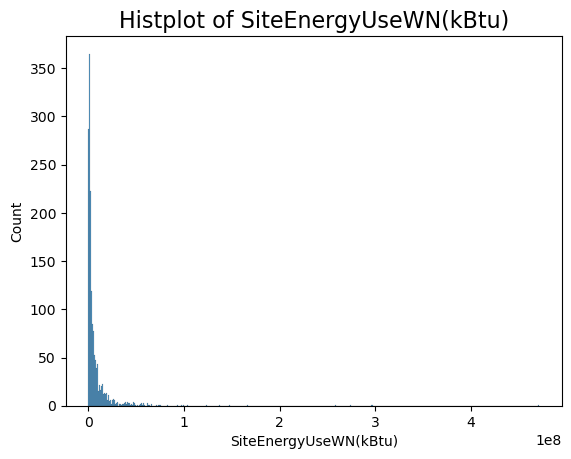

In [82]:
#plt.figure(figsize=(15,5))
sns.histplot(data=data, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

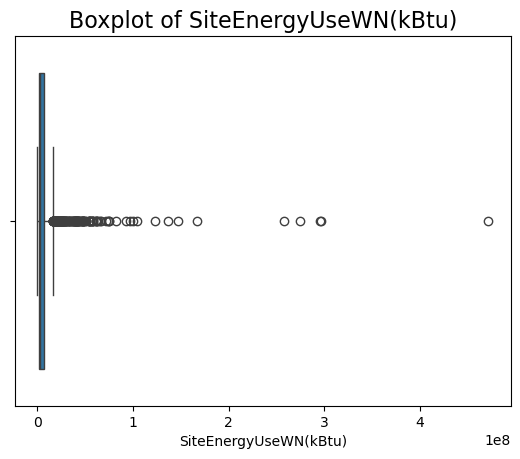

In [83]:
sns.boxplot(x=data['SiteEnergyUseWN(kBtu)'])
plt.title('Boxplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

On constate la pr√©sence de nombreux outliers qui viennent perturber la visualisation.

On peut aussi regarder la m√©thode bas√©e sur l'IQR pour idnetifier les valeurs aberrantes. L'IQR est la diff√©rence entre le 25e centile (Q1) et le 75e centile (Q3) des donn√©es. Les valeurs :

inf√©rieures √† Q1 - 1,5 * IQR
ou sup√©rieures √† Q3 + 1,5 * IQR
sont consid√©r√©es comme aberrantes.

In [85]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['SiteEnergyUseWN(kBtu)'].quantile(0.25)
Q3 = data['SiteEnergyUseWN(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kBtu")
print("limite haute :", round(limite_haute,2), "kBtu")

limite basse : 0 kBtu
limite haute : 16262938.3 kBtu


Combien de propri√©t√©s sont au-dessus de la limite haute ?

In [87]:
mask = data['SiteEnergyUseWN(kBtu)'] > limite_haute
print("Nombre de propri√©t√©s au-dessus de la limite haute :", data.loc[mask].shape[0])

Nombre de propri√©t√©s au-dessus de la limite haute : 177


Quel est le "complianceStatus" de ces propri√©t√©s ?

In [89]:
data.loc[mask, 'ComplianceStatus'].value_counts()

ComplianceStatus
Compliant    177
Name: count, dtype: int64

On voit ici la faible utilit√© de la variable ComplianceStatus

Quelle est la distribution sans ces propri√©t√©s ?

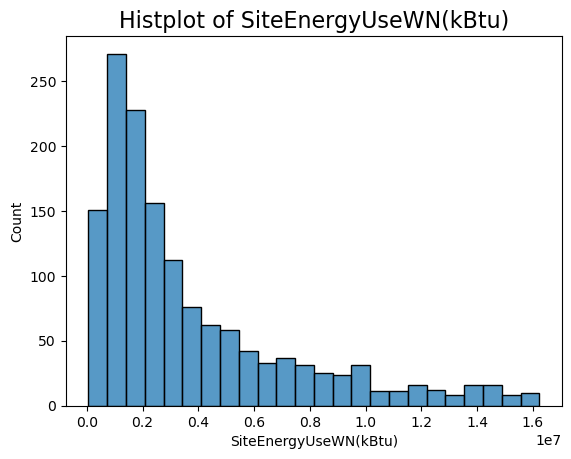

In [92]:
mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
sample = data.loc[mask]
sns.histplot(data=sample, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

On visualise une distribution unimodale asym√©trique (√©talement √† droite).

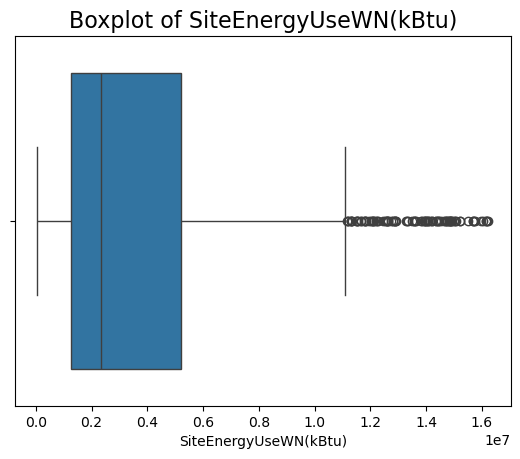

In [94]:
sns.boxplot(x=sample['SiteEnergyUseWN(kBtu)'])
plt.title('Boxplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

Est-ce que ces valeurs "aberrantes" ont un lien avec la surface du b√¢timent ?

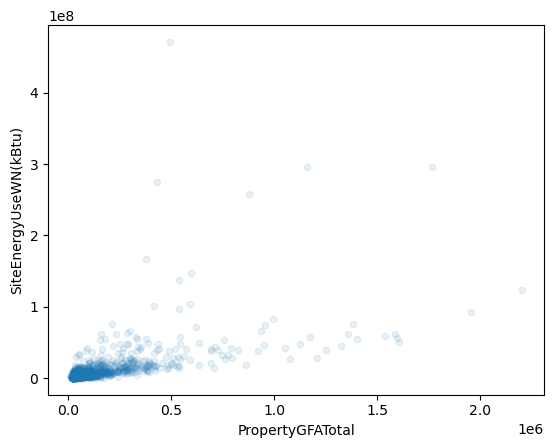

In [96]:
# Cr√©ation du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

On voit ici que les valeurs de consommation au-dessus de 1,6e8 ne s'expliquent pas forc√©ment par la superficie du b√¢timent.

Je vais donc supprimer du dataset les valeurs au-dessus de la limite haute.

In [98]:
mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
data = data.loc[mask]

In [99]:
data.shape

(1445, 46)

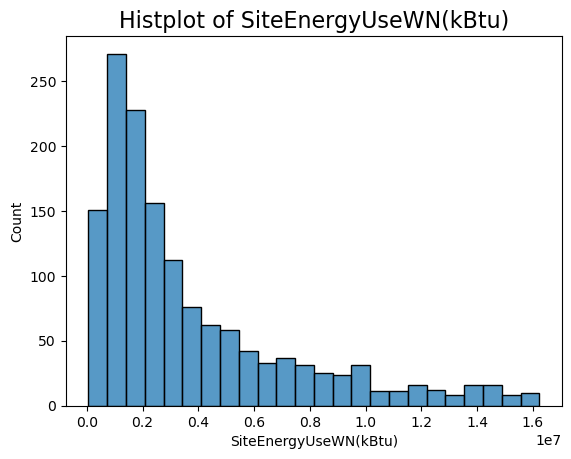

In [100]:
sns.histplot(data=sample, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

**Traiter les donn√©es manquantes**

Identifier les valeurs NaN :

In [102]:
mask = data['SiteEnergyUseWN(kBtu)'].isna()
print("Nombre de propri√©t√©s dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propri√©t√©s dont la valeur est manquante : 0


Identifier les valeurs nulles :

In [104]:
mask = data['SiteEnergyUseWN(kBtu)'] == 0
print("Nombre de propri√©t√©s dont la valeur est nulle :", data.loc[mask].shape[0])

Nombre de propri√©t√©s dont la valeur est nulle : 0


In [105]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1445.000000        1445.000000     1445.000000       1445.000000   
mean   1960.210381           1.022145        3.078201      69280.738408   
std      32.678129           0.435040        3.746112      70740.623113   
min    1900.000000           0.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28072.000000   
50%    1963.000000           1.000000        2.000000      43661.000000   
75%    1987.000000           1.000000        4.000000      78374.000000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.445000e+03      1.445000e+03    1.445000e+03   
mean        2.492841e+06      1.018276e+06    9.451563e+04   
std         2.744288e+06      1.505151e+06    5.616864e+05   
min        -1.154170e+05      0.000000e+00    0.000000e+00   
25%         6.781670e+05      0.000000e+00    0.000000e+00   
50%         1.357120e+06      4.768320e+05    0.000000e+00   
75%         3.327045e+06      1.239357e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.445000e+03        1445.000000  
mean            3.767918e+06          78.754754  
std             3.595049e+06          95.616344  
min             5.811420e+04          -0.800000  
25%             1.259282e+06          18.620000  
50%             2.340056e+06          43.450000  
75%             5.205994e+06          95.860000  
max             1.622816e+07         712.390000

#### 6.4 - Nettoyer les donn√©es de la variable cible TotalGHGEmissions

**Traiter les valeurs aberrantes**

On voit qu'il y a des valeurs n√©gatives, ce qui est aberrant ici.

On supprime les valeurs n√©gatives :

In [108]:
mask = data['TotalGHGEmissions'] >= 0
print("Nombre de valeurs n√©gatives :", data.shape[0] - data.loc[mask].shape[0])
data = data.loc[mask]

Nombre de valeurs n√©gatives : 1


In [109]:
data.shape

(1444, 46)

In [110]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.022161        3.076177      69292.705679   
std      32.659878           0.435190        3.746620      70763.667283   
min    1900.000000           0.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

Visualiser la distribution :

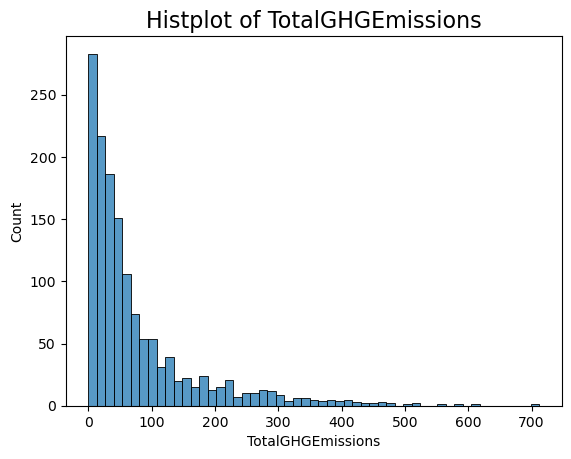

In [112]:
sns.histplot(data=data, x='TotalGHGEmissions')
plt.title('Histplot of TotalGHGEmissions', fontsize=16)
plt.show()

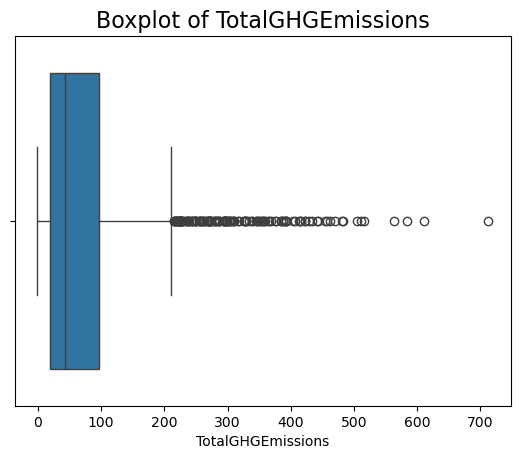

In [113]:
sns.boxplot(x=sample['TotalGHGEmissions'])
plt.title('Boxplot of TotalGHGEmissions', fontsize=16)
plt.show()

Visualiser le lien entre les √©missions et la consommation d'energie :

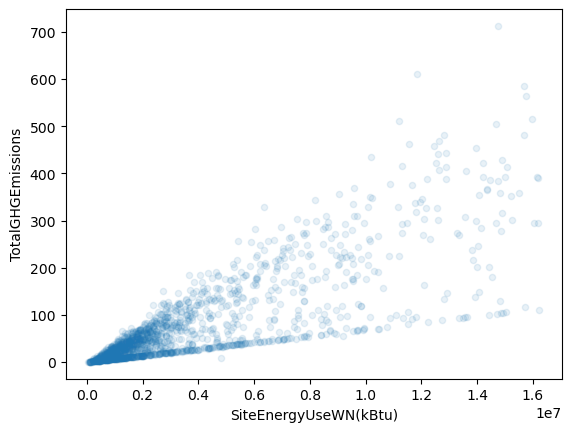

In [115]:
# Cr√©ation du scatter plot
data.plot.scatter(x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

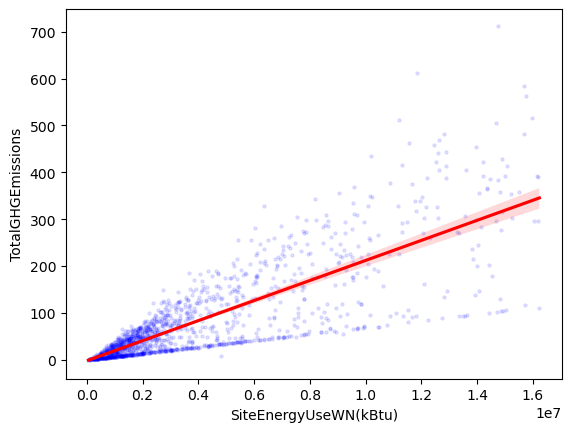

In [116]:
# Afficher le regplot
sns.regplot(x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions', data=data, color='blue', marker='o', line_kws={'color': 'red'}, scatter_kws={'s': 5, 'alpha': 0.1})

# Afficher le graphique
plt.show()

Ce diagramme montre clairement une corr√©lation positive entre la consommation d'√©nergie sur le site (SiteEnergyUseWN) et les √©missions de gaz √† effet de serre totales (TotalGHGEmissions). Plus l'utilisation d'√©nergie est grande, plus les √©missions de GES augmentent. Cependant, la dispersion indique que la relation n'est pas parfaitement lin√©aire et qu'il pourrait y avoir d'autres variables en jeu.

**Traiter les donn√©es manquantes**

Identifier les valeurs NaN :

In [119]:
mask = data['TotalGHGEmissions'].isna()
print("Nombre de propri√©t√©s dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propri√©t√©s dont la valeur est manquante : 0


Identifier les valeurs nulles :

In [121]:
mask = data['TotalGHGEmissions'] == 0
print("Nombre de propri√©t√©s dont la valeur est nulle :", data.loc[mask].shape[0])

Nombre de propri√©t√©s dont la valeur est nulle : 0


Pas besoin de traiter les valeurs manquantes ou nulles car il n'y en a pas.

In [123]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.022161        3.076177      69292.705679   
std      32.659878           0.435190        3.746620      70763.667283   
min    1900.000000           0.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.5 - Nettoyer la feature YearBuilt

**Traiter les valeurs aberrantes**

Les ann√©es de construction s'√©talent entre 1900 et 2015.

In [125]:
data['YearBuilt'].dtypes

dtype('int64')

Cette feature est de type entier. Il n'y a donc pas √† priori de valeurs aberrantes.

Visualiser la distribution:

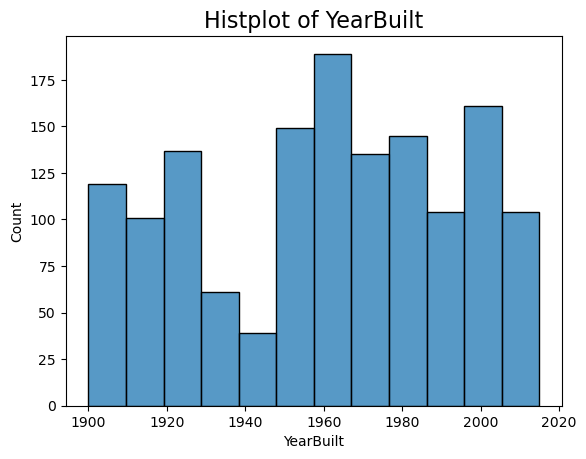

In [127]:
sns.histplot(data=data, x='YearBuilt')
plt.title('Histplot of YearBuilt', fontsize=16)
plt.show()

Visualiser les corr√©lations avec les cibles :

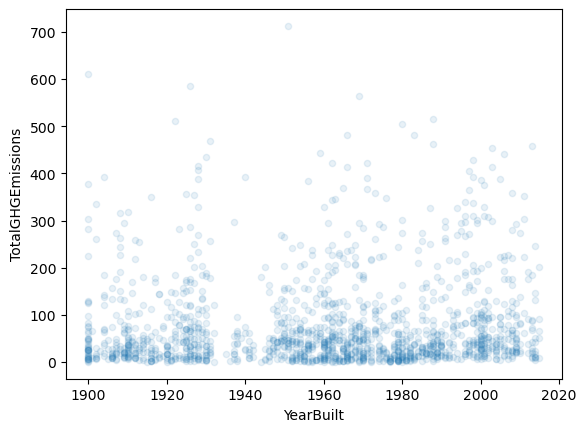

In [129]:
# Cr√©ation du scatter plot
data.plot.scatter(x='YearBuilt', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

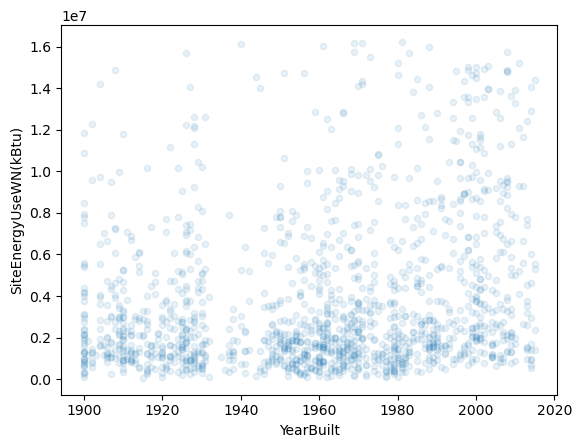

In [130]:
# Cr√©ation du scatter plot
data.plot.scatter(x='YearBuilt', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes**

Identifier les valeurs manquantes :

In [132]:
mask = data['YearBuilt'].isna()
print("Nombre de propri√©t√©s dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propri√©t√©s dont la valeur est manquante : 0


Pas de donn√©es manquantes ici.

#### 6.6 - Nettoyer les donn√©es de la feature NumberofBuildings

**Traiter les valeurs aberrantes**

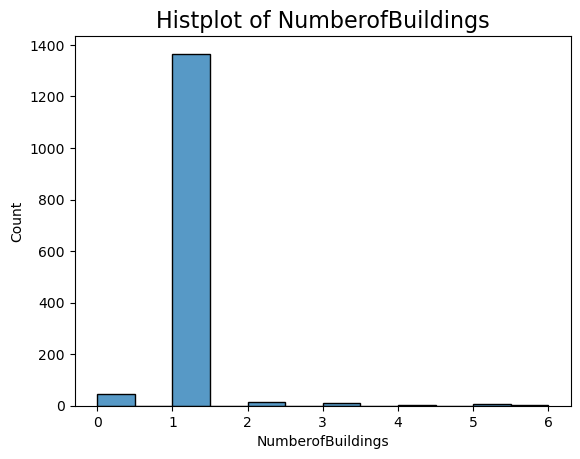

In [135]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

In [136]:
data['NumberofBuildings'].dtypes

dtype('float64')

Certaines valeurs ne sont pas des entiers, ce qui n'est pas normal. 

Rechercher les valeurs qui ne sont pas des entiers :

In [138]:
# Filtrer les valeurs qui ne sont pas des entiers
valeurs_non_entieres = data[~data['NumberofBuildings'].apply(lambda x: isinstance(x, int))]
print(valeurs_non_entieres['NumberofBuildings'])

0       1.0
1       1.0
3       1.0
4       1.0
5       1.0
       ... 
3371    1.0
3372    1.0
3373    1.0
3374    1.0
3375    1.0
Name: NumberofBuildings, Length: 1444, dtype: float64


In [139]:
data['NumberofBuildings'].unique()

array([1., 0., 2., 3., 6., 5., 4.])

Il n'y a que 0 qui est une valeur aberrante, car il devrait y avoir au moins un b√¢timent. On va les transformer en NaN.

In [141]:
# remplacer dans le dataset
mask = data['NumberofBuildings'] == 0.
data.loc[mask, 'NumberofBuildings'] = np.nan

In [142]:
data['NumberofBuildings'].unique()

array([ 1., nan,  2.,  3.,  6.,  5.,  4.])

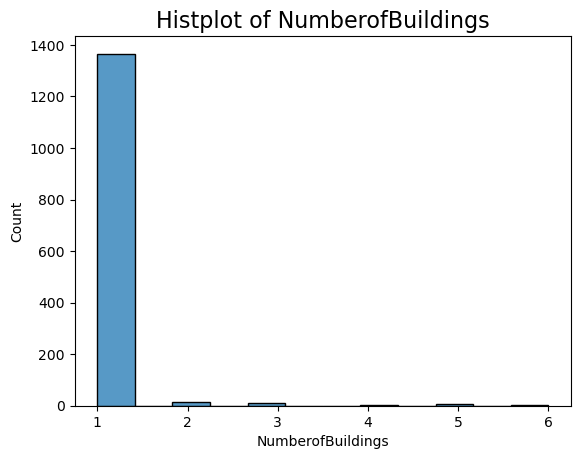

In [143]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

**Traiter les valeurs manquantes**

Nombre de valeurs manquantes :

In [145]:
mask = data['NumberofBuildings'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 44


In [146]:
# Diagramme en secteurs
def build_pieplot(series, variable_label):
    plt.figure(figsize=(6, 6))
    plt.pie(series, 
            labels=series.index, 
            autopct='%1.1f%%',  # Affiche les pourcentages avec 1 d√©cimale
            startangle=140,     # Angle de d√©part pour la premi√®re tranche
            wedgeprops=dict(edgecolor='black'))  # Couleur de la bordure des secteurs
    
    plt.title('Diagramme en secteurs de la variable ' + variable_label, fontsize=16)
    # Cette ligne assure que le pie chart est un cercle plut√¥t qu'une √©llipse
    plt.axis('equal')
    # Personnaliser la taille des labels des secteurs
    plt.setp(plt.gca().texts, fontsize=12)  # Taille des √©tiquettes des secteurs
    plt.setp(plt.gca().patches, edgecolor='black')  # Couleur des bordures des secteurs
    
    plt.show()

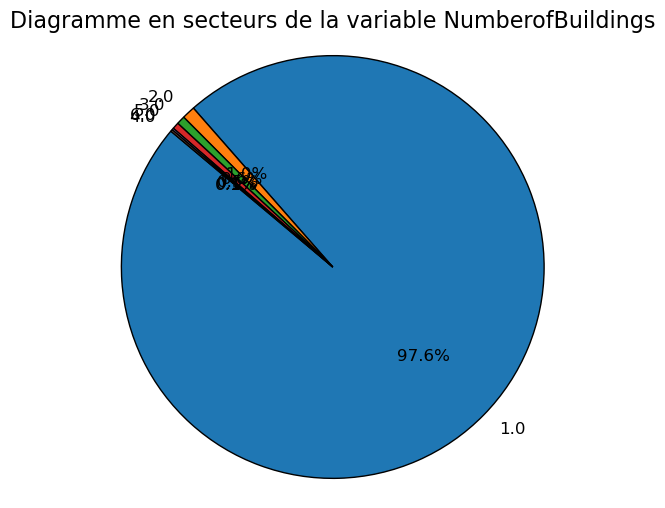

In [147]:
build_pieplot(data['NumberofBuildings'].value_counts(), 'NumberofBuildings')

Le nombre de b√¢timent par propri√©t√© est 1 pour 97.6%. Je propose donc de remplacer les valeurs manquantes par 1 qui est la valeur majoritaire :

In [149]:
mask = data['NumberofBuildings'].isna()
data.loc[mask, 'NumberofBuildings'] = 1

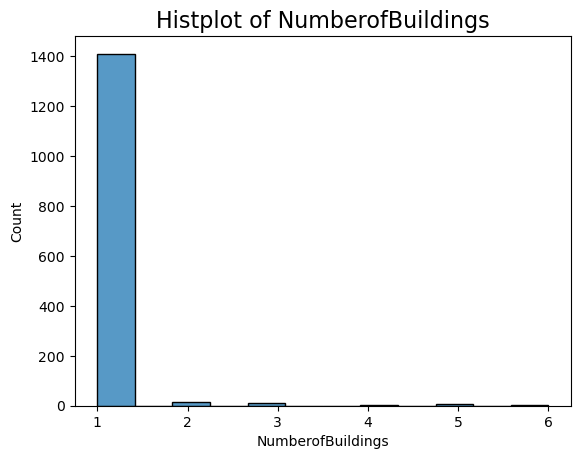

In [150]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

La distribution ne change pas beaucoup. Seule la 1er barre est un peu plus haute.

In [152]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      69292.705679   
std      32.659878           0.395750        3.746620      70763.667283   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.7 - Nettoyer les donn√©es de la variable NumberofFloors

**Traiter le valeurs aberrantes:**

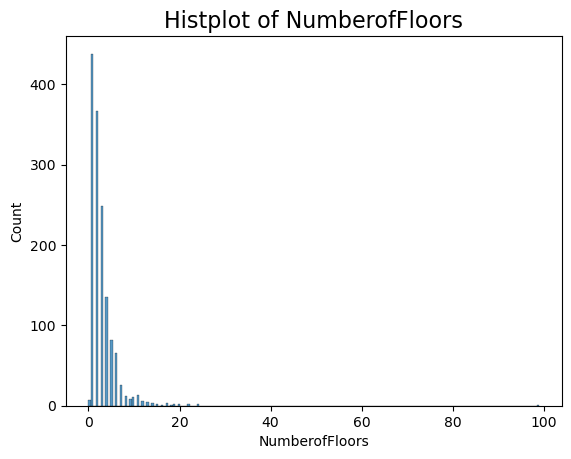

In [154]:
sns.histplot(data=data, x='NumberofFloors')
plt.title('Histplot of NumberofFloors', fontsize=16)
plt.show()

In [155]:
data['NumberofFloors'].dtypes

dtype('int64')

Il n'y a pas de valeurs aberrantes √† priori. 0 n'est pas une valeur aberrante, car un b√¢timent de plein pieds n'a pas d'√©tage.

**Traiter les valeurs manquantes:**

In [158]:
mask = data['NumberofFloors'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y pas de valeurs manquantes.

In [160]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      69292.705679   
std      32.659878           0.395750        3.746620      70763.667283   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     706176.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.8 - Nettoyer les donn√©es de la feature PropertyGFATotal

**Traiter les valeurs aberrantes:**

Visualiser la distribution:

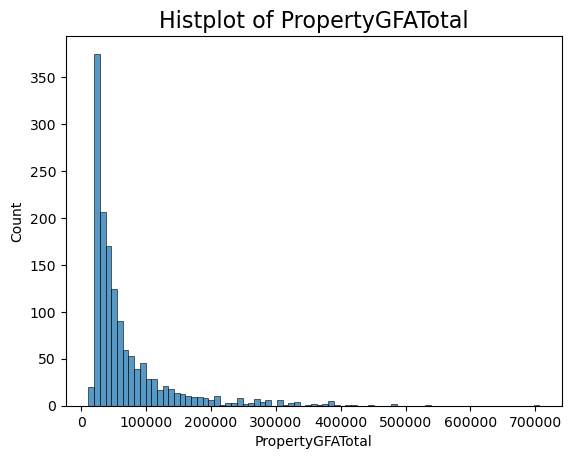

In [162]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

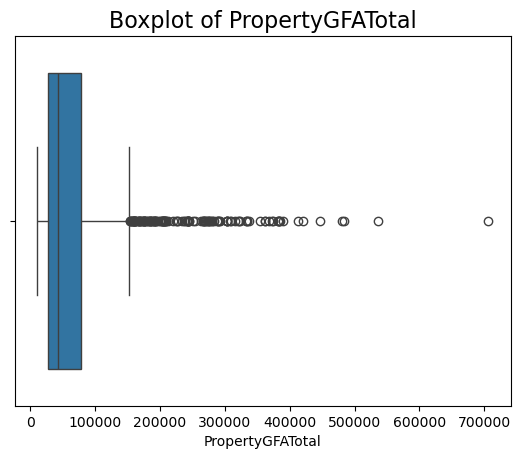

In [163]:
sns.boxplot(x=sample['PropertyGFATotal'])
plt.title('Boxplot of PropertyGFATotal', fontsize=16)
plt.show()

Rechercher les outliers par la m√©thode de l'IQR:

In [165]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['PropertyGFATotal'].quantile(0.25)
Q3 = data['PropertyGFATotal'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "pieds carr√©s")
print("limite haute :", round(limite_haute,2), "pieds carr√©s")

limite basse : 0 pieds carr√©s
limite haute : 153858.88 pieds carr√©s


Combien de propri√©t√©s sont au-dessus de la limite haute :

In [167]:
mask = data['PropertyGFATotal'] > limite_haute
print("Nombre de propri√©t√©s au-dessus de la limite haute :", data.loc[mask].shape[0])

Nombre de propri√©t√©s au-dessus de la limite haute : 134


Font-ils partis des erreurs dans le complianceStatus ?

In [169]:
mask = (data['PropertyGFATotal'] > limite_haute) & (data['ComplianceStatus'] == 'Error - Correct Default Data')
print("Nombre de propri√©t√©s au-dessus de la limite haute et en erreur sur le complianceStatus:", data.loc[mask].shape[0])

Nombre de propri√©t√©s au-dessus de la limite haute et en erreur sur le complianceStatus: 11


On peut essayer de voir s'il y a une variable corr√©l√©e qui pourrait justifier les valeurs au-dessus de la limite haute.

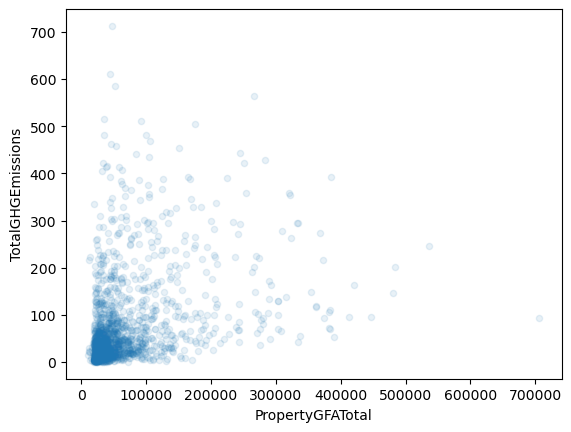

In [171]:
# Cr√©ation du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

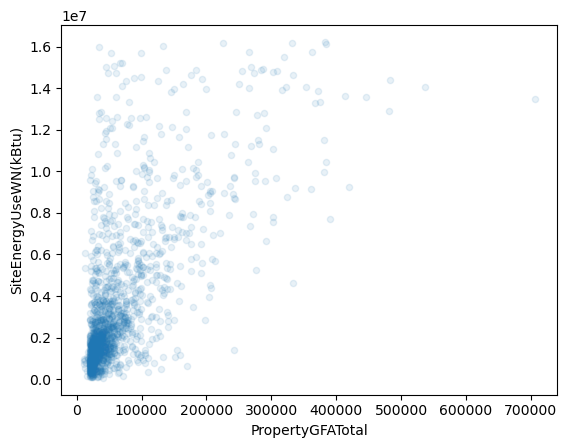

In [172]:
# Cr√©ation du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

D'apr√®s ChatGPT, Un immeuble de bureaux de 700 000 pieds carr√©s correspondrait √† un gratte-ciel ou √† un immeuble de grande hauteur, typique des centres-villes ou des quartiers d'affaires majeurs.

Il est donc difficile de consid√©rer les valeurs au-dessus de la limite haute comme aberrante.

Quel est le nombre d'√©tages du 700 000 ?

In [174]:
mask = data['PropertyGFATotal'] > 700000
print("Nombre d'√©tages des propri√©t√©s au-dessus de 700 000 :", data.loc[mask, 'NumberofFloors'].values)

Nombre d'√©tages des propri√©t√©s au-dessus de 700 000 : [6]


6 Etages c'est peu. Le b√¢timent avec 700 000 de PropertyGFATotal est donc aberrant.

On le transform en NaN.

In [176]:
# remplacer dans le dataset
mask = data['PropertyGFATotal'] > 700000.
data.loc[mask, 'PropertyGFATotal'] = np.nan

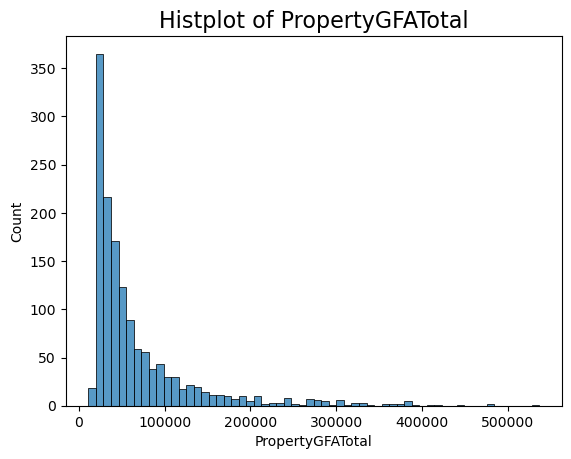

In [177]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

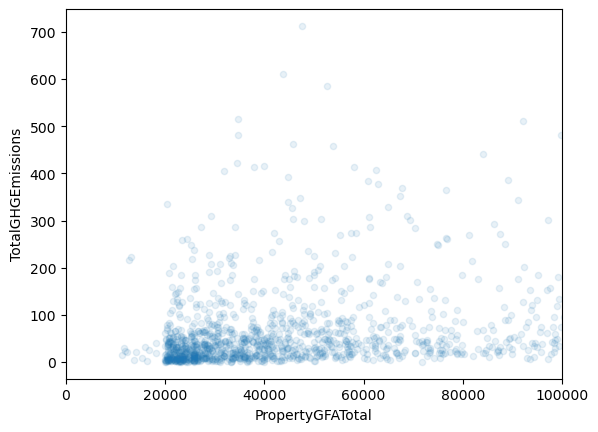

In [178]:
# Cr√©ation du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='TotalGHGEmissions', alpha=0.1)

# D√©finir les limites de l'axe x
plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

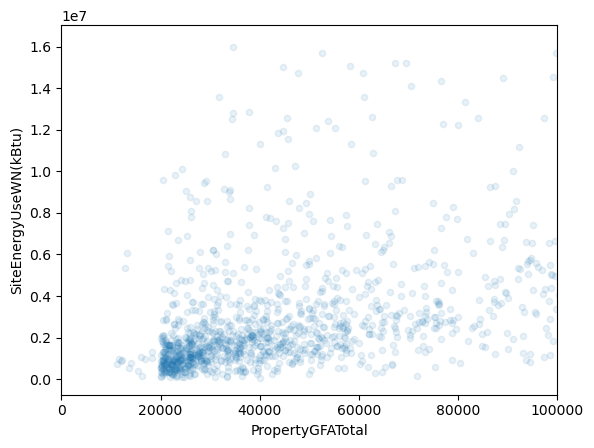

In [179]:
# Cr√©ation du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# D√©finir les limites de l'axe x
plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes:**

Identifier les valeurs manquantes :

In [181]:
mask = data['PropertyGFATotal'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 1


Il y a une valeur NaN. Quelles sont les caract√©ristiques de cette propri√©t√© ?

In [183]:
print(data.loc[mask])

      OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
2835          27145      2016  NonResidential        Large Office   

                        PropertyName      Address     City State  ZipCode  \
2835  719 2nd Ave (Millennium Tower)  719 2nd Ave  Seattle    WA  98104.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
2835                    5530510000                    7     DOWNTOWN   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
2835  47.60331 -122.33389       2000                1.0               6   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
2835               NaN                   0                  706176   

         ListOfAllPropertyUseTypes LargestPropertyUseType  \
2835  Bank Branch, Office, Parking                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
2835                   222807.0                      Parking   

      SecondLarge

Elle a 1 b√¢timent et 6 √©tages. Quelle est la distribution de cette cat√©gorie ?

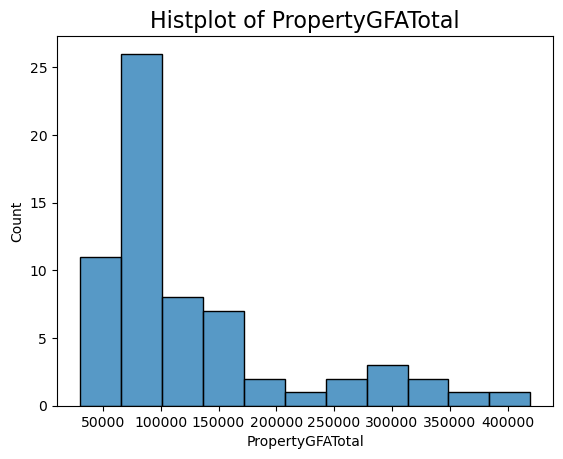

In [185]:
mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
sns.histplot(data=data.loc[mask], x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

Comme la distribution est asym√©trique, je propose de remplacer le Nan par la m√©diane de cette cat√©gorie.

In [187]:
# Calculer la m√©diane
mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
median = data.loc[mask, 'PropertyGFATotal'].median()
print("mediane = ", str(median))

mediane =  95740.5


In [188]:
mask = data['PropertyGFATotal'].isna()
data.loc[mask, 'PropertyGFATotal'] = median

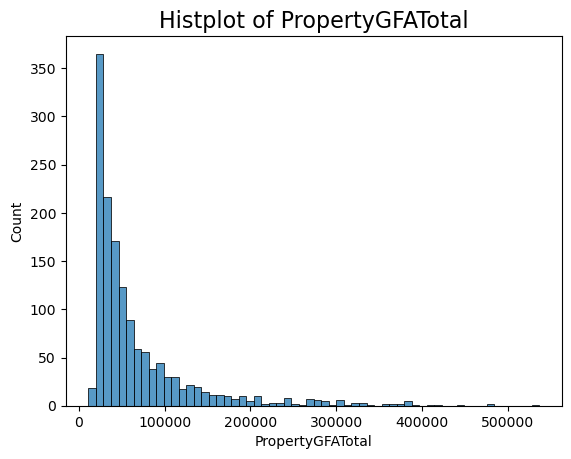

In [189]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

Identifier les valeurs nulles :

In [191]:
mask = data['PropertyGFATotal'] == 0
print("Nombre de valeurs nulles :", data.loc[mask].shape[0])

Nombre de valeurs nulles : 0


Il n'y a pas de valeurs nulles.

In [193]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.494647e+06      1.018981e+06    9.458109e+04   
std         2.744379e+06      1.505434e+06    5.618755e+05   
min         0.000000e+00      0.000000e+00    0.000000e+00   
25%         6.783500e+05      0.000000e+00    0.000000e+00   
50%         1.357482e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.8 - Nettoyer les donn√©es de la feature Electricity(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

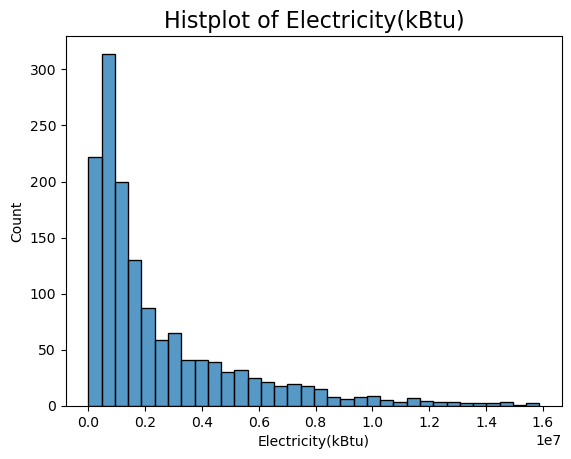

In [195]:
sns.histplot(data=data, x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu)', fontsize=16)
plt.show()

Distribution unimodale, asym√©trique, avec √©talement √† droite. 

D'apr√®s ChatGPT :
- Les immeubles de bureaux consomment souvent entre 1 et 10 millions de kBtu par an, selon leur taille et leur utilisation.
- Des b√¢timents tr√®s √©nergivores (comme les centres commerciaux, les h√¥pitaux, ou les data centers) peuvent atteindre 10 √† 50 millions de kBtu par an, voire plus.

Tous les b√¢timents doivent avoir une consommation √©lectrique non nulle, car ils consomment n√©cessairement de l'electricit√©, ne serait-ce que pour l'√©clairage. Combien de propri√©t√© consomme 0 kBtu d'√©lectricit√© :

In [197]:
mask = data['Electricity(kBtu)'] == 0
print("Nombre de propri√©t√©s avec 0 kBtu de consommation √©lectrique :", data.loc[mask].shape[0])

Nombre de propri√©t√©s avec 0 kBtu de consommation √©lectrique : 1


In [198]:
print(data.loc[mask])

     OSEBuildingID  DataYear    BuildingType PrimaryPropertyType PropertyName  \
426          23854      2016  NonResidential          Restaurant      Pier 57   

              Address     City State  ZipCode TaxParcelIdentificationNumber  \
426  1301 Alaskan Way  Seattle    WA  98101.0                    7666202435   

     CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
426                    7     DOWNTOWN  47.60613 -122.34115       1900   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
426                1.0               1           43728.0                   0   

     PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
426                   43728                Restaurant             Restaurant   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
426                    43728.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
426           

On transforme les valeurs 0 en NaN :

In [200]:
# remplacer dans le dataset
mask = data['Electricity(kBtu)'] == 0
data.loc[mask, 'Electricity(kBtu)'] = np.nan

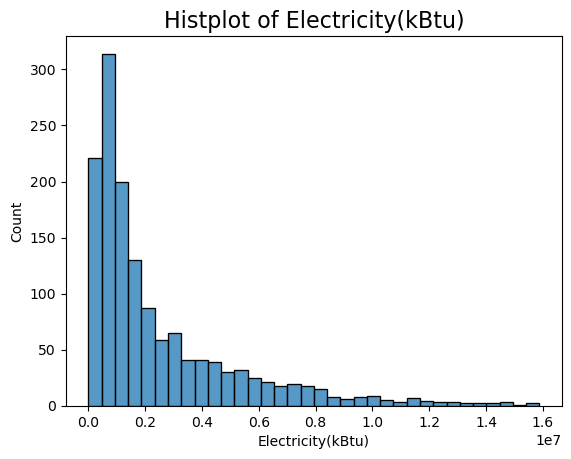

In [201]:
sns.histplot(data=data, x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu)', fontsize=16)
plt.show()

Visualiser les corr√©altions √©ventuelles avec les cibles :

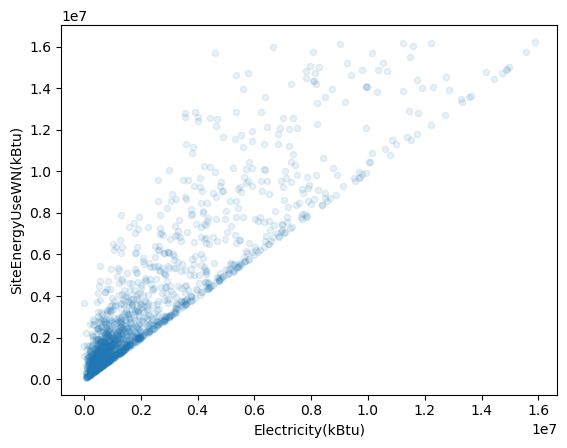

In [203]:
# Cr√©ation du scatter plot
data.plot.scatter(x='Electricity(kBtu)', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# D√©finir les limites de l'axe x
#plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

Il n'y a pas de points sous la diagonale dans ce graphique car la consommation totale d'√©nergie d'un site (Site Energy Use WN), repr√©sent√©e sur l'axe ùë¶, inclut n√©cessairement la consommation d'√©lectricit√© (Electricity), repr√©sent√©e sur l'axe ùë•.

On observe une tendance lin√©aire claire o√π la consommation totale d‚Äô√©nergie du site augmente avec la consommation d‚Äô√©lectricit√© (corr√©lation positive).
Cela indique que l‚Äô√©lectricit√© constitue probablement une part importante de la consommation √©nerg√©tique totale. Les deux variables sont fortement li√©es.

Les points proches de la diagonale sugg√®rent que, l‚Äô√©lectricit√© repr√©sente une proportion majeure de la consommation √©nerg√©tique totale (peut-√™tre 100 %, ou presque).

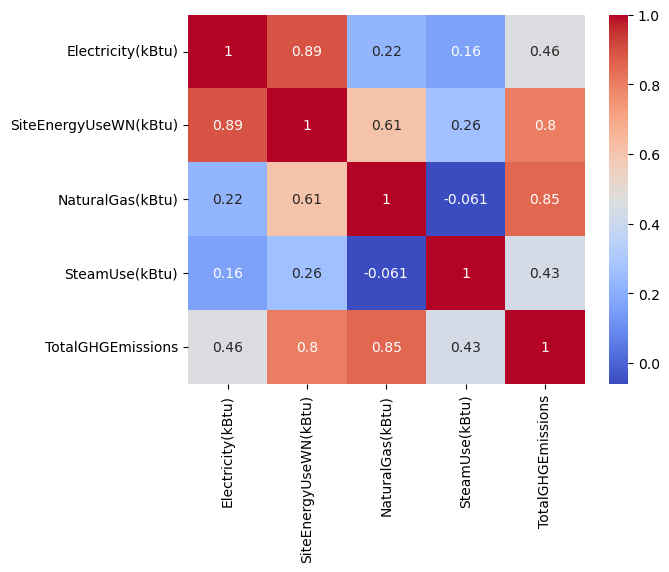

In [205]:
correlation_matrix = data[['Electricity(kBtu)', 'SiteEnergyUseWN(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'TotalGHGEmissions']].corr()

# Cr√©er une heatmap pour la matrice de corr√©lation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

L'observation est confirm√©e par le calcul du coefficient de corr√©lation entre la consommation √©lectrique et la consommation totale.

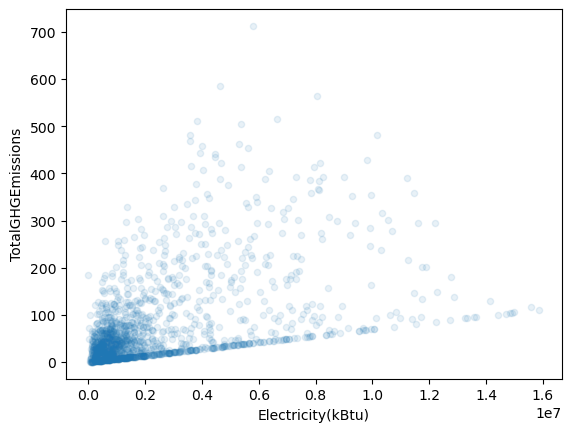

In [207]:
# Cr√©ation du scatter plot
data.plot.scatter(x='Electricity(kBtu)', y='TotalGHGEmissions', alpha=0.1)

# D√©finir les limites de l'axe x
#plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes**

In [209]:
mask = data['Electricity(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 1


Quel est le type de propri√©t√© ?

In [211]:
print("Type de propri√©t√© :", data.loc[mask, 'PrimaryPropertyType'])

Type de propri√©t√© : 426    Restaurant
Name: PrimaryPropertyType, dtype: object


Visualiser la distribution des propri√©t√©s de type "Restaurant"

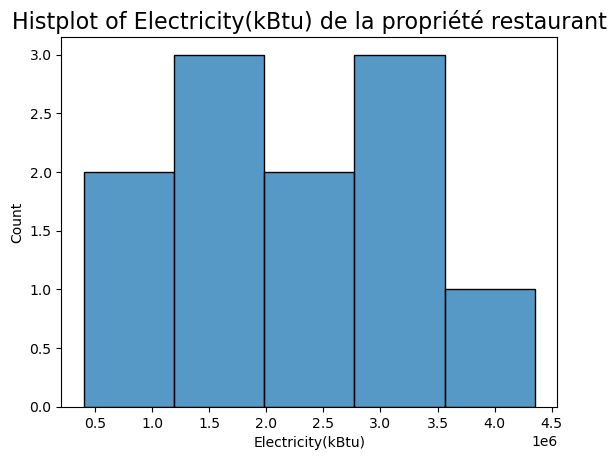

In [213]:
mask = data['PrimaryPropertyType'] == 'Restaurant'
sns.histplot(data= data.loc[mask], x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu) de la propri√©t√© restaurant', fontsize=16)
plt.show()

Je propose de remplacer le NaN par la moyenne :

In [215]:
# Calculer la moyenne des restaurants
mask = data['PrimaryPropertyType'] == 'Restaurant'
mean = data.loc[mask, 'Electricity(kBtu)'].mean()
print("moyenne = ", str(mean))

moyenne =  2177533.4545454546


In [216]:
mask = data['Electricity(kBtu)'].isna()
data.loc[mask, 'Electricity(kBtu)'] = mean

In [217]:
mask = data['Electricity(kBtu)'].isna()
print(data.loc[mask].shape[0])

0


In [218]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.9 - Nettoyer les donn√©es de la feature NaturalGas(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

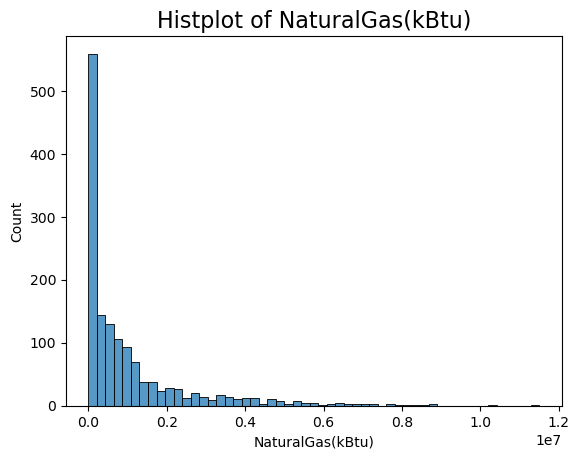

In [220]:
sns.histplot(data=data, x='NaturalGas(kBtu)')
plt.title('Histplot of NaturalGas(kBtu)', fontsize=16)
plt.show()

La distribution est unimodale, asym√©trique, avec √©talement √† droite. Le nombre important de valeurs nulles s'explique par le fait que beaucoup de b√¢timents ne sont pas n√©cessairement ratacch√©s au gaz.

D'apr√®s ChatGPT : 
"
Je ne dispose pas de chiffres pr√©cis et r√©cents pour cette question sp√©cifique, mais des rapports de la ville de Seattle indiquent souvent des tendances g√©n√©rales :

- Seattle est connue pour son engagement envers les √©nergies renouvelables et la r√©duction des combustibles fossiles.
- Une proportion significative des b√¢timents utilise l'√©lectricit√©, notamment gr√¢ce √† la production hydro√©lectrique qui domine l'approvisionnement en √©lectricit√© de Seattle.
- La ville a des objectifs ambitieux de r√©duction des √©missions de carbone, ce qui a incit√© certains b√¢timents √† abandonner le gaz naturel pour passer √† des sources d'√©nergie plus propres, notamment l'√©lectricit√©.
"

Les valeurs nulles ne peuvent donc pas √™tre consid√©r√©es comme aberrantes.

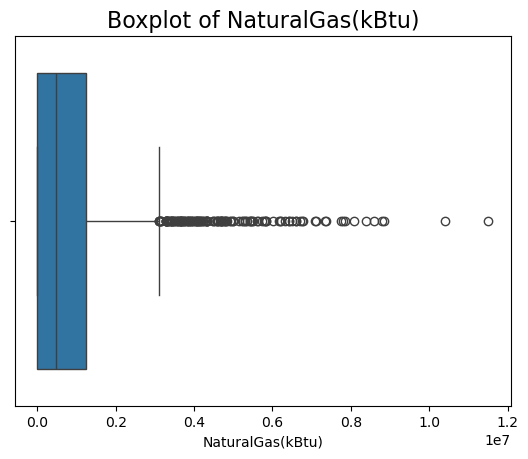

In [382]:
sns.boxplot(x=sample['NaturalGas(kBtu)'])
plt.title('Boxplot of NaturalGas(kBtu)', fontsize=16)
plt.show()

Quelles sont les types de propri√©t√©s des b√¢timents de plus de 0,8 * 1e7 kBtu ?

In [389]:
mask = data['NaturalGas(kBtu)'] > 0.8 * 1e7
print("Nombre de b√¢timents concern√©s :", data.loc[mask].shape[0])

print("Liste des types de propri√©t√©s correspondantes :", data.loc[mask, 'PrimaryPropertyType'].unique())

Nombre de b√¢timents concern√©s : 7
Liste des types de propri√©t√©s correspondantes : ['Hotel' 'Mixed Use Property' 'Restaurant' 'Senior Care Community' 'Other']


Rechercher les outliers par la m√©thode inter quartile IQR :

In [392]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['NaturalGas(kBtu)'].quantile(0.25)
Q3 = data['NaturalGas(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kBtu")
print("limite haute :", round(limite_haute,2), "kBtu")

limite basse : 0 kBtu
limite haute : 3098502.5 kBtu


In [400]:
mask = data['NaturalGas(kBtu)'] > limite_haute
print("Nombre de b√¢timents au-dessus la limite haute :", data.loc[mask].shape[0])

Nombre de b√¢timents au-dessus la limite haute : 140


In [396]:
print("Liste des types de propri√©t√©s correspondantes :", data.loc[mask, 'PrimaryPropertyType'].unique())

Liste des types de propri√©t√©s correspondantes : ['Hotel' 'Other' 'University' 'K-12 School' 'Mixed Use Property'
 'Warehouse' 'Retail Store' 'Large Office' 'Supermarket / Grocery Store'
 'Laboratory' 'Distribution Center' 'Small- and Mid-Sized Office'
 'Restaurant' 'Medical Office' 'Senior Care Community' 'Worship Facility']


Je ne pense que l'IQR soit pertinent ici, car la consommation de gaz diff√©re beaucoup selon l'utilisation de la propri√©t√©. Par exemple la forte consommation de gaz n'est pas aberrante pour les grands h√¥tels, et pour les restaurants.

Je ne consid√®re donc pas ces valeurs comme aberrantes. En effet il faudrait √©tudier chaque propri√©t√©, une √† une, ce qui prendrait trop de temps, ne serait pas forc√©ment pertinent pour un 1er feature engineering.

**Traiter les valeurs manquantes**

In [403]:
mask = data['NaturalGas(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y a pas de valeurs manquantes ici.

In [461]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.10 - Nettoyer les donn√©es de la feature SteamUse(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

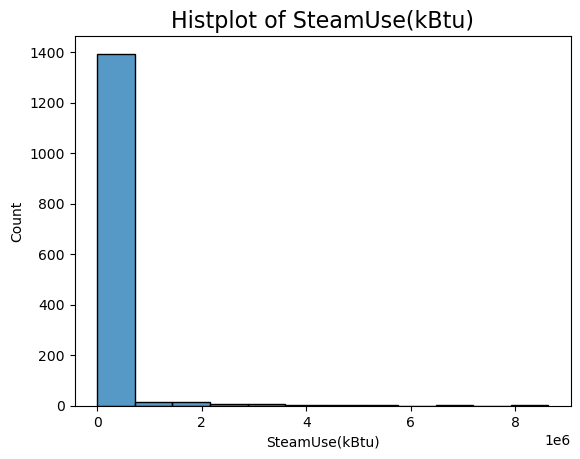

In [410]:
sns.histplot(data=data, x='SteamUse(kBtu)')
plt.title('Histplot of SteamUse(kBtu)', fontsize=16)
plt.show()

La distribution est unimodale, asym√©trique. Le pic √† 0 s'explique par une faible utilisation de la vapeur comme source d'√©nergie.

D'apr√®s ChatGPT, une consommation de 8 millions de kBtu ne serait pas aberrante. D'o√π d√©pend de l'usage du b√¢timent. Je ne consid√®re donc pas les valeurs √©lev√©es comme aberrantes √† ce stade du projet. En effet il faudrait √©tudier chaque propri√©t√©, une √† une, ce qui prendrait trop de temps, ne serait pas forc√©ment pertinent pour un 1er feature engineering.

**Traiter les valeurs manquantes**

In [415]:
mask = data['SteamUse(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y a pas de valeurs manquantes.

In [463]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

#### 6.11 - Sauvegarder le dataset nettoy√©

In [429]:
data.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_cleaned.csv', index=False)

#### 6.12 - Automatisation du nettoyage r√©alis√©

Cr√©er la fonction de nettoyage :

In [506]:
def clean(data):
    
    # SiteEnergyUseWN(kBtu)
    
    ## On calcule l'IQR (intervalle interquartile)
    Q1 = data['SiteEnergyUseWN(kBtu)'].quantile(0.25)
    Q3 = data['SiteEnergyUseWN(kBtu)'].quantile(0.75)
    IQR = Q3 - Q1
    
    ## On calcule les limites
    limite_basse = max(0, Q1 - 1.5 * IQR)
    limite_haute = Q3 + 1.5 * IQR
    
    ## Suppression des valeurs au-dessus de la limite haute
    mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
    data = data.loc[mask]
    
    # TotalGHGEmissions
    
    ## Suppression des valeurs n√©gatives
    mask = data['TotalGHGEmissions'] >= 0
    data = data.loc[mask]
    
    # YearBuilt - pas de besoin
    
    ## NumberofBuildings
    
    ## remplacer les valeurs nulles dans le dataset
    mask = data['NumberofBuildings'] == 0.
    data.loc[mask, 'NumberofBuildings'] = np.nan
    
    ## remplacer les valeurs manquantes par 1 qui est la valeur majoritaire
    mask = data['NumberofBuildings'].isna()
    data.loc[mask, 'NumberofBuildings'] = 1
    
    # NumberofFloors - pas de besoin
    
    # PropertyGFATotal
    
    ## remplacer dans le dataset
    mask = data['PropertyGFATotal'] > 700000.
    data.loc[mask, 'PropertyGFATotal'] = np.nan
    
    ## Calculer la m√©diane pour remplacer les valeurs manquantes par la m√©diane
    mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
    median = data.loc[mask, 'PropertyGFATotal'].median()
        
    mask = data['PropertyGFATotal'].isna()
    data.loc[mask, 'PropertyGFATotal'] = median
    
    # Electricity(kBtu)
    
    ## remplacer dans le dataset
    mask = data['Electricity(kBtu)'] == 0
    data.loc[mask, 'Electricity(kBtu)'] = np.nan
    
    ## Calculer la moyenne des restaurants
    mask = data['PrimaryPropertyType'] == 'Restaurant'
    mean = data.loc[mask, 'Electricity(kBtu)'].mean()
        
    mask = data['Electricity(kBtu)'].isna()
    data.loc[mask, 'Electricity(kBtu)'] = mean
    
    # NaturalGas(kBtu) - pas de besoin
    
    # SteamUse(kBtu) - pas de besoin
    
    return data

On peut rejouer tout ce qui a √©t√© fait depuis le d√©but :

In [508]:
# Charger le fichier de donn√©es
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)

In [510]:
data = select_dataset(data)

In [512]:
data = delete_outliers(data)

In [514]:
data = clean(data)

In [516]:
data.shape

(1444, 46)

In [520]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [522]:
data[features_fe1].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1444.000000        1444.000000     1444.000000       1444.000000   
mean   1960.173823           1.052632        3.076177      68869.966413   
std      32.659878           0.395750        3.746620      68751.053439   
min    1900.000000           1.000000        0.000000      11285.000000   
25%    1929.000000           1.000000        1.000000      28062.000000   
50%    1963.000000           1.000000        2.000000      43653.000000   
75%    1987.000000           1.000000        4.000000      78380.750000   
max    2015.000000           6.000000       99.000000     536697.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.444000e+03      1.444000e+03    1.444000e+03   
mean        2.496155e+06      1.018981e+06    9.458109e+04   
std         2.743606e+06      1.505434e+06    5.618755e+05   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.785962e+05      0.000000e+00    0.000000e+00   
50%         1.358182e+06      4.783005e+05    0.000000e+00   
75%         3.331490e+06      1.239401e+06    0.000000e+00   
max         1.587869e+07      1.150804e+07    8.630381e+06   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
count           1.444000e+03        1444.000000  
mean            3.770361e+06          78.809848  
std             3.595094e+06          95.626523  
min             5.811420e+04           0.400000  
25%             1.259692e+06          18.627500  
50%             2.343374e+06          43.540000  
75%             5.206862e+06          95.877500  
max             1.622816e+07         712.390000

In [524]:
data[features_fe1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 0 to 3375
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PrimaryPropertyType    1444 non-null   object 
 1   Neighborhood           1444 non-null   object 
 2   YearBuilt              1444 non-null   int64  
 3   NumberofBuildings      1444 non-null   float64
 4   NumberofFloors         1444 non-null   int64  
 5   PropertyGFATotal       1444 non-null   float64
 6   Electricity(kBtu)      1444 non-null   float64
 7   NaturalGas(kBtu)       1444 non-null   float64
 8   SteamUse(kBtu)         1444 non-null   float64
 9   SiteEnergyUseWN(kBtu)  1444 non-null   float64
 10  TotalGHGEmissions      1444 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 135.4+ KB


#### 6.11 - Filtrer les features

Liste des features :

In [526]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']

In [546]:
X_fe1 = data[features_fe1].copy()
X_fe1.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
3               Hotel     DOWNTOWN       1926                1.0   
4               Hotel     DOWNTOWN       1980                1.0   
5               Other     DOWNTOWN       1999                1.0   

   NumberofFloors  PropertyGFATotal  Electricity(kBtu)  NaturalGas(kBtu)  \
0              12           88434.0          3946027.0         1276453.0   
1              11          103566.0          3242851.0         5145082.0   
3              10           61320.0          2768924.0         1811213.0   
4              18          175580.0          5368607.0         8803998.0   
5               2           97288.0          7371434.0         4715182.0   

   SteamUse(kBtu)  
0      2003882.00  
1            0.00  
3      2214446.25  
4            0.00  
5            0.00

#### 6.12 - Extraire les 2 cibles

In [530]:
y_fe1_conso = data['SiteEnergyUseWN(kBtu)']
y_fe1_conso.shape

(1444,)

In [532]:
y_fe1_emission = data['TotalGHGEmissions']
y_fe1_emission.shape

(1444,)

#### 6.12 - Transformer la feature YearBuilt en feature par plage de date

Visualier la distribution :

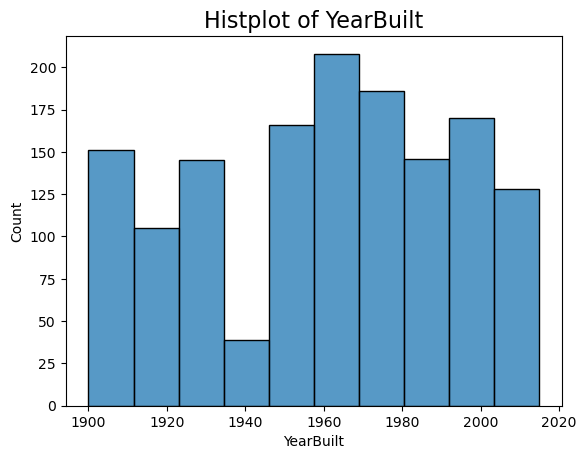

In [534]:
sns.histplot(data=data, x='YearBuilt', bins=10)
plt.title('Histplot of YearBuilt', fontsize=16)
plt.show()

In [548]:
# Cr√©er 5 bins automatiques
X_fe1['YearBuilt_Bin'] = pd.cut(X_fe1['YearBuilt'], bins=10)

In [550]:
X_fe1.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
3               Hotel     DOWNTOWN       1926                1.0   
4               Hotel     DOWNTOWN       1980                1.0   
5               Other     DOWNTOWN       1999                1.0   

   NumberofFloors  PropertyGFATotal  Electricity(kBtu)  NaturalGas(kBtu)  \
0              12           88434.0          3946027.0         1276453.0   
1              11          103566.0          3242851.0         5145082.0   
3              10           61320.0          2768924.0         1811213.0   
4              18          175580.0          5368607.0         8803998.0   
5               2           97288.0          7371434.0         4715182.0   

   SteamUse(kBtu)     YearBuilt_Bin  
0      2003882.00  (1923.0, 1934.5]  
1            0.00  (1992.0, 2003.5]  
3      2214446.25  (1923.0, 1934.5]  
4            0.00  (1969.0, 1980.5]  
5            0.00  (1992.0, 2003.5]

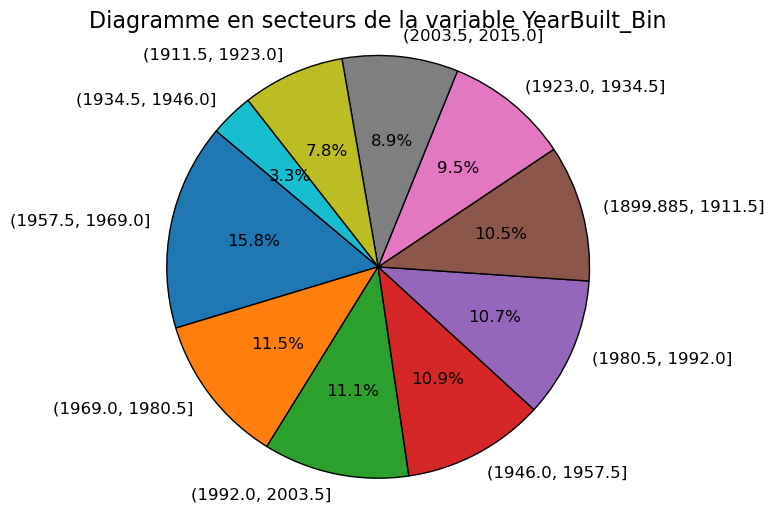

In [554]:
build_pieplot(X_fe1['YearBuilt_Bin'].value_counts(), 'YearBuilt_Bin')

#### 6.13 - Num√©riser les variables cat√©gorielles PrimaryPropertyType, Neighborhood et YearBuilt_Bin

On va utiliser le oneHotEncoding pour le 1er feature engineering

In [563]:
# Initialiser l'encodeur
encoder = OneHotEncoder()

# Appliquer l'encodeur √† une colonne sp√©cifique
columns = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt_Bin']
encoded_columns = encoder.fit_transform(X_fe1[columns])

# Ajouter les colonnes encod√©es dans le DataFrame original
encoded_X_fe1 = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columns))
X_fe1 = pd.concat([X_fe1, encoded_X_fe1], axis=1)

In [565]:
X_fe1.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN     1927.0                1.0   
1               Hotel     DOWNTOWN     1996.0                1.0   
3               Hotel     DOWNTOWN     1926.0                1.0   
4               Hotel     DOWNTOWN     1980.0                1.0   
5               Other     DOWNTOWN     1999.0                1.0   

   NumberofFloors  PropertyGFATotal  Electricity(kBtu)  NaturalGas(kBtu)  \
0            12.0           88434.0          3946027.0         1276453.0   
1            11.0          103566.0          3242851.0         5145082.0   
3            10.0           61320.0          2768924.0         1811213.0   
4            18.0          175580.0          5368607.0         8803998.0   
5             2.0           97288.0          7371434.0         4715182.0   

   SteamUse(kBtu)     YearBuilt_Bin  PrimaryPropertyType_Distribution Center  \
0      2003882.00  (1923.0, 1934.5]                                      0.0   
1            0.00  (1992.0, 2003.5]                                      0.0   
3      2214446.25  (1923.0, 1934.5]                                      0.0   
4            0.00  (1969.0, 1980.5]                                      0.0   
5            0.00  (1992.0, 2003.5]                                      0.0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                           0.0                        1.0   
1                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        0.0   
5                           0.0                        1.0   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Laboratory  \
0                              0.0                             0.0   
1                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
5                              0.0                             0.0   

   PrimaryPropertyType_Large Office  PrimaryPropertyType_Low-Rise Multifamily  \
0                               0.0                                       0.0   
1                               0.0                                       0.0   
3                               0.0                                       0.0   
4                               0.0                                       0.0   
5                               0.0                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   
5                                 0.0                                     0.0   

   PrimaryPropertyType_Office  PrimaryPropertyType_Other  \
0                         0.0                        0.0   
1                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        1.0   
5                         0.0                        0.0   

   PrimaryPropertyType_Refrigerated Warehouse  \
0                                         0.0   
1                                         0.0   
3                                         0.0   
4                                         0.0   
5                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
0                                 0.0                             0.0   
1                                 0.0                             0.0   
3           